# Deep Learning for Computer Vision:  HW 4

## Computer Science: COMS W 4995 004

### Due: November 2, 2020

### Problem

In this notebook we provide three networks for classifying handwritten digits from the MNIST dataset. The networks are implemented and tested using the Tensorflow framework. The third and final network is a convolutional neural network (CNN aka ConvNet) which achieves 99.18% accuracy on this dataset. 

Your task is to re-implement all three networks using Pytorch. You will likely find several Pytorch implementations on the internet. It is ok to study these. However, you must not cut and paste this code into your assignment--you must write this yourself. Furthermore, you need to comment every line of code and succintly explain what it is doing! 

Here is what is required:

a) A FULLY commented re-implementation of the networks below using Pytorch.

b) your network trained on the same MNIST data as used here.

c) an evaluation of the accuracy on the MNIST test set.

d) plots of 10 randomly selected digits from the test set along with the correct label and the assigned label.

e) have your training record a log of the validation loss and validation accuracy. 

f) have your training continually save the best model so far (as determined by the validation loss).

g) after training, load the saved weights using the best model so far. re-run you accuracy evaluation using these saved weights.

Below we include the Tensorflow examples shown in class.

### A Simple Convolutional Neural Network in Tensorflow

This notebook covers a python and tensorflow-based solution to the handwritten digits recognition problem. It is based on tensorflow tutorials and Yann LeCun's early work on CNN's. This toturial compares a simple softmax regressor, a multi-layer perceptron (MLP), and a simple convolutional neural network (CNN).

Load in the MNIST digit dataset directly from tensorflow examples.

In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). 

Let's import tensorflow and begin an interactive session.

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

## Softmax Regression Model on the MNIST Digits Data

We need to create placeholders for the data. Data will be dumped here when it is batched from the MNIST dataset.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Now let's see what this data looks like.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(4):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

We are first going to do softmax logistic regression. This is a linear layer followed by softmax. Note there are NO hidden layers here. Also note that the digit images (28x28 grayscale images) are reshaped into a 784 element vector. 

Below we create the parameters (weights) for our linear layer.

In [ ]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

We then use tensorflows initializer to initialize these weights.

In [ ]:
sess.run(tf.global_variables_initializer())

We create our linear layer as a function of the input and the weights.

In [ ]:
y_regressor = tf.matmul(x,W) + b

Below we create our loss function. Note that the cross entropy is $ H_{\hat{y}}(y) = -\sum_i \hat{y}_{i} \, \log(y_{i})$ where $\hat{y}$ is the true probability distribution and is expressed as a one-hot vector, $y$ is the estimated probability distribution, and $i$ indexes elements of these two vectors. Also note that this reduces to $ H_{\hat{y}}(y) = -\, \log(y_{i^*})$ where $i^*$ is the correct label. And if we sum this over all of our samples indexed by $j$, then $H_{\hat{y}}(y) = -\sum_j  \log(y^{(j)}_{i^*})$. This is precisely the same loss function as we used before, but we called the MLE loss. They are one and the same.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_regressor))

Now we tell tf to use gradient descent with a step size of 0.5 and to minimize the cross entropy.

In [ ]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

We train by grabbing mini-batches with 100 samples each and pushing these through the network to update our weights (W and b).

In [ ]:
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

We define how to compute correct predicitions.

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_regressor,1), tf.argmax(y_,1))

And from these correct predictions how to compute the accuracy.

In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

Let's print out some test images and the corresponsing predictions made by the network. But first, let's add an output to the computation graph that computes the softmax probabilities.

In [ ]:
y_probs_regressor = tf.nn.softmax(logits=y_regressor, name=None)

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print("Label = ", label)
    print("Class probabilities = ", y_probs_regressor.eval(feed_dict={
        x: batch[0], y_: batch[1]}))

## Softmax Multi-Layer Perceptron on the MNIST Digits Data

Here we define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLU. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we create placeholders for the training data.

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

We create the first and only fully connected hidden layer.

In [ ]:
W_h = weight_variable([784, 512])
b_h = bias_variable([512])
h = tf.nn.relu(tf.matmul(x, W_h) + b_h)

We create the output layer.

In [ ]:
W_out = weight_variable([512, 10])
b_out = bias_variable([10])
y_MLP = tf.matmul(h, W_out) + b_out

We again use cross entropy loss on a softmax distribution on the outputs.

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_MLP))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training. Note this softmax MLP network does quite a bit bettter than our softmax regressor. The non-linear layer really helps makes sense of the data! But we can do better still...

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_MLP,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1]})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels}))

## A Simple Convolutional Neural Network: LeNet

Here we make our first CNN. It's quite simple network, but it's surprisingly good at this handwritten digit recognition task. This a variant on Yann LeCun's CNN network that really helped to move deep learning forward.

We define both weight and bias variables and how they are to be initialized. Note that the weights are are distributed according to a standard normal distribution (mean = 0, std = 0.1). This random initialization helps avoid hidden units get stuck together, as units that start with the same value will be updated identically in the non-convolutional layers. In contrast, the bias variables are set to a small positive number--this is help prevent hidden units from starting out and getting stuck in the zero part of the ReLu. 

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Next we define how the convolution is to be computed and the extent and type of pooling. The convolution will use a 5x5 kernel and will pad the image with zeros around the edges and use a stride of 1 pixel so that the resulting image (after convolution) has the same size as the original input image. The network will learn the weights for a stack of 32 separate kernels along with 32 bias variables. Finally, after the ReLu is performed the result will be under go 2x2 max pooling, thus halfing both dimensions of the image. The choices for the stride, padding, and pooling are not parameters that the network needs to estimate. Rather these are termed "hyperparamters" that are usually set by the network designer.

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

This creates the weight and bias variables for the first convolutional layer as described above. Note the output has depth 32, so there will be 32 feature images after this layer.

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

Unlike for our softmax regressor above, here we need keep the images as images and not collapse these into vectors; this allows us to perform the 2D convolution.

In [ ]:
x_image = tf.reshape(x, [-1,28,28,1])

Finally, we define are first layer of our CNN!

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

And wasting no time, we define are second layer. The second layer will have to process 32 feature images coming out of the first layer. Note that the images input to this layer have $\frac{1}{4}$ the number of pixels as the original input images due to the 2x2 pooling in the previous layer. Note that convolution layer NOT fully connected as our previous hidden layers have been. A unit in the output layer has a limited "receptive field." Its connections to the input layer are spatially limited by the kernel (or filter) size. Also, because of weight sharing in convolutional layers, the number of parameters for a convolutional is the size of the kernel x the depth of the input layer x depth of the output layer + depth of the output layer. So for the second layer of our ConvNet, we have 5 x 5 x 32 x 64 + 64 = 51,264 parameters. 

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

After the pooling stage of our second convolutional layer, we have 64 7x7 "feature" images. In one penultimate fully connected hidden layer, we are going to map these feature imges to a 1024 dimensional feature space. Note we need to flatten these feature images to do this.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Dropout is added here, although it is not really needed for such small network.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

We have a final linear output layer mapping features to scores topped off with a softmax cross entropy loss function, as explained earlier.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

For training we choose an Adam learning rate and update rule. We then run this for 20,000 iterations and evaluate our accuracy after training.

In [ ]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%1000 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

We add an output to compuational graph that computes the label probabilities.

In [ ]:
y_probs = tf.nn.softmax(logits=y_conv, name=None)

In [ ]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Next we step through some test examples and see how well the network is doing.

In [ ]:
for i in range(5):
    batch = mnist.test.next_batch(1)
    image = np.asarray(batch[0]).reshape((28, 28))
    label = batch[1]
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print "Label = ", label
    print "Class probabilities = ", y_probs.eval(feed_dict={
        x: batch[0], y_: batch[1], keep_prob: 1.0})

## All parts of this assignment (a-g) are incorporated into each of the three models built using PyTorch, defined below:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch #import pytorch
import torchvision.datasets #torchvision is a library in pytorch that has datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

### 1) Simple Softmax Regressor

In [2]:
#get the train, test, and validation sets for pytorch using MNIST
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) #here we initialize the mnist training set (to be split up later)
#split the dataset (originally train) into train and validation sets, 75/25
train_size = int(0.75*len(dataset))
val_size = int(0.25*len(dataset))
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size]) #here we initialize train and validation sets
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) #here we initialize the mnist test set

In [3]:
#Step 1: Load and prepare dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
valloader = torch.utils.data.DataLoader(testset, batch_size=4)

In [4]:
#Step 2: Define a model
class SSR(nn.Module):
    def __init__(self, input_dim, output_dim): #we must define the number of input units and output units
        super(SSR, self).__init__() #super calls the __init__ method of the parent class, here nn.Module
        self.linear = nn.Linear(input_dim, output_dim) #applies linear transformation
        
    def forward(self, x): #our method for forward propogation
        output = self.linear(x) #call nn.Linear to apply the linear transformation
        return output
    
SSR_model = SSR(784, 10)

In [5]:
#Step 3: Define training options
criterion = nn.CrossEntropyLoss() #compute softmax cross entropy loss
optimizer = optim.SGD(SSR_model.parameters(), lr=0.001, momentum=0.9) #use stochastic gradient descent as our learning algorithm

#### Training the network and evaluating accuracy

In [1]:
#Step 4: Train the network
best_val_loss = 1 #for keeping track of best (lowest) validation loss across all epochs
best_epoch = 1 #for keeping track of the best epoch based on validation loss

for epoch in range(10): #let's do 10 epochs
    
    train_loss_per_epoch = [] #keep a list of the losses for each epoch, then take the average loss for one epoch
    validation_loss = [] #keep a running list of the losses on the validation data
    running_loss = 0.0 #initialize loss to 0
    
    for i, (images, labels) in enumerate(trainloader): #go through each image/label in the training data
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) ##reshape images to work with model class (28*28)
        labels = Variable(labels) #get the labels
        optimizer.zero_grad() #zero the parameter gradients
        outputs = SSR_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #backpropogate, computes the gradients
        optimizer.step() #optimize
        
        #print stats
        running_loss += loss.item() #add up losses
        if i % 128 == 127: #print every mini-batch of size 128
            train_loss_per_epoch.append(running_loss/128)
            running_loss = 0.0 #reset loss
            
    print('epoch: ', epoch + 1, 'training loss: ', sum(train_loss_per_epoch)/len(train_loss_per_epoch))
            
    #run the validation set through the network, check for loss and accuracy
    for i, (images, labels) in enumerate(valloader): #go through each image/label in the validation data
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
        labels = Variable(labels) #get the labels
        optimizer.zero_grad() #zero the parameter gradients
        outputs = SSR_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        #calculate gradient of matrix
        loss.backward() #backpropogate
        #apply gradient from last step to matrix
        optimizer.step() #optimize
        running_loss += loss.item() #add up losses
        
    val_loss = running_loss/len(valloader) #divide running loss by the length of valloader to get the average loss
    print('epoch: ', epoch + 1, 'validation loss:', val_loss) #we run on entire set, not in mini-batches
    
    if val_loss < best_val_loss: #check which epoch is best based on lowest validation loss
        torch.save(SSR_model, '../Desktop/SSR_model.pt') #save the model
        best_val_loss = val_loss #save the new best (lowest) loss
        best_epoch = epoch + 1 #save the best epoch
    
#Step 5: Evaluate the network
    correct = 0 #initialize number correct to 0
    total = 0 #initialize total to 0

    with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
        for data in valloader: #compute accuracy on validation data
            images, labels = data #our data consists of (images, labels)
            #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
            images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
            outputs = SSR_model(images) #get outputs from our model from forward prop
            _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
            total += labels.size(0) #total number of labels
            correct += (predicted == labels).sum().item() #total number of correct predictions

    accuracy = correct/total
    print('epoch: ', epoch + 1, 'validation accuracy: %.4f' % accuracy)
        
            
print('FINISHED TRAINING')
print('best epoch for this model: ', best_epoch)

NameError: name 'trainloader' is not defined

#### Parts d, g) Now that we know our best epoch for this model, we'll load the model and run our test data on that. Then we'll plot 10 randomly selected digits and report their predicted and actual labels.

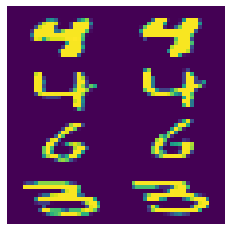

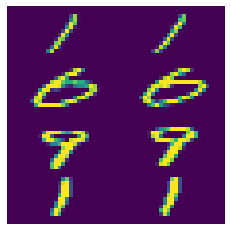

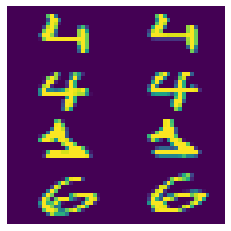

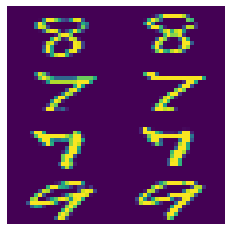

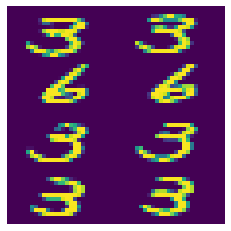

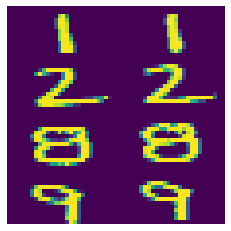

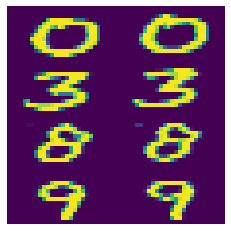

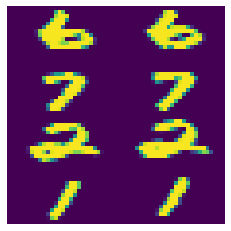

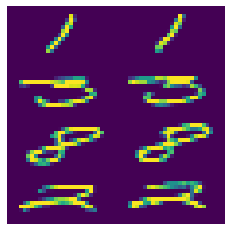

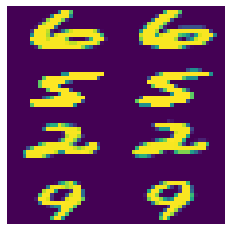

testing accuracy: 0.9312
predicted labels:  [tensor([4, 4, 6, 3]), tensor([1, 0, 9, 1]), tensor([4, 4, 6, 6]), tensor([8, 7, 7, 9]), tensor([3, 6, 3, 3]), tensor([1, 2, 8, 9]), tensor([0, 3, 8, 9]), tensor([6, 7, 2, 1]), tensor([1, 3, 8, 2]), tensor([6, 5, 2, 9])]
actual labels:  [tensor([4, 4, 6, 3]), tensor([1, 6, 9, 1]), tensor([4, 4, 1, 6]), tensor([8, 7, 7, 9]), tensor([3, 6, 3, 3]), tensor([1, 2, 8, 9]), tensor([0, 3, 8, 9]), tensor([6, 7, 2, 1]), tensor([1, 3, 8, 2]), tensor([6, 5, 2, 9])]


In [7]:
SSR_model = torch.load('../Desktop/SSR_model.pt') #load the model that we saved for the best epoch
SSR_model.eval() #evaluate the model

correct = 0 #initialize number correct to 0
total = 0 #initialize total to 0
random_digits = random.sample(range(0, len(testloader)), 10) #generate 10 UNIQUE random digits for getting 10 random images
counter = 0 #see if counter == a number in random_digits
random_predicted = [] #list of predicted values for the 10 random images
random_labels = [] #list of correct labels for the 10 random images

with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
    for data in testloader: #compute accuracy on testing data
        images, labels = data
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
        outputs = SSR_model(images) #get outputs from our model from forward prop
        _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
        total += labels.size(0) #total number of labels
        correct += (predicted == labels).sum().item() #total number of correct predictions
        if counter in random_digits: #check to see if our counter is in the random_digits list we created
            random_predicted.append(predicted) #add the respective image's predicted value to our predicted list
            random_labels.append(labels) #add the respective image's actual value to our labels list
            plt.imshow(images.reshape((56,56))) #shape of the image is 56,56 and needs to be reshaped to be shown
            plt.axis("off")
            plt.show()
        counter += 1 #increment counter
        
accuracy = correct/total #accuracy is the number correctly predicted divided by total number of labels
print('testing accuracy: %.4f' % accuracy)
print('predicted labels: ', random_predicted)
print('actual labels: ', random_labels)

### 2) MLP

In [8]:
#get the train, test, and validation sets for pytorch using MNIST
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) #here we initialize the mnist training set (to be split up later)
#split the dataset (originally train) into train and validation sets, 75/25
train_size = int(0.75*len(dataset))
val_size = int(0.25*len(dataset))
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size]) #here we initialize train and validation sets
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) #here we initialize the mnist test set

In [9]:
#Step 1: Load and prepare dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
valloader = torch.utils.data.DataLoader(testset, batch_size=4)

In [10]:
#Step 2: Define a model
class MLP(nn.Module):
    #to make this an MLP, we'll have three hidden layers
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size): #for an MLP we have input, hidden layers, output
        super(MLP, self).__init__() #super calls the __init__ method of the parent class, here nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size1) #applies a linear transformation, first hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size2) #applies a linear transformation, second hidden layer
        self.fc3 = nn.Linear(hidden_size2, hidden_size3) #applies a linear transformation, third hidden layer
        self.relu = nn.ReLU() #outputs non-linear information
        self.fc4 = nn.Linear(hidden_size3, output_size) #applies a linear transformation
        self.sigmoid = nn.Sigmoid() #sigmoid function for MLP
        
    def forward(self, x):
        output = self.fc1(x) #first hidden layer
        output = self.fc2(output) #second hidden layer
        output = self.fc3(output) #third hidden layer
        output = self.relu(output) #apply relu activation
        output = self.fc4(output) #output layer
        output = self.sigmoid(output) #apply sigmoid calculation
        return output #return result
    
MLP_model = MLP(784, 500, 500, 500, 10) #784 inputs, hidden layer sizes are all 500, output size is 10

In [11]:
#Step 3: Define training options
criterion = nn.CrossEntropyLoss() #compute softmax cross entropy loss
optimizer = optim.SGD(MLP_model.parameters(), lr=0.001, momentum=0.9) #use stochastic gradient descent as our learning algorithm

#### Training the network and evaluating accuracy

In [12]:
#Step 4: Train the network
best_val_loss = 1 #for keeping track of best (lowest) validation loss across all epochs
best_epoch = 1 #for keeping track of the best epoch based on validation loss

for epoch in range(10): #let's do 10 epochs
    
    train_loss_per_epoch = [] #keep a list of the losses for each epoch, then take the average loss for one epoch
    validation_loss = [] #keep a running list of the losses on the validation data
    running_loss = 0.0 #initialize loss to 0
    
    for i, (images, labels) in enumerate(trainloader): #go through each image/label in the training data
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
        labels = Variable(labels) #get the labels
        optimizer.zero_grad() #zero the parameter gradients
        outputs = MLP_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #backpropogate, computes the gradients
        optimizer.step() #optimize
        
        #print stats
        running_loss += loss.item() #add up losses
        if i % 128 == 127: #print every mini-batch of size 128
            train_loss_per_epoch.append(running_loss/128)
            running_loss = 0.0 #reset loss
            
    print('epoch: ', epoch + 1, 'training loss: ', np.log(sum(train_loss_per_epoch)/len(train_loss_per_epoch)))
            
    #run the validation set through the network, check for loss and accuracy
    for i, (images, labels) in enumerate(valloader): #go through each image/label in the validation data
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
        labels = Variable(labels) #get the labels
        optimizer.zero_grad() #zero the parameter gradients
        outputs = MLP_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        #calculate gradient of matrix
        loss.backward() #backpropogate
        #apply gradient from last step to matrix
        optimizer.step() #optimize
        running_loss += loss.item() #add up losses
            
    val_loss = np.log(running_loss/len(valloader)) #divide running loss by the length of valloader to get the average loss
    print('epoch: ', epoch + 1, 'validation loss:', val_loss) #we run on entire set, not in mini-batches
    
    if val_loss < best_val_loss: #check which epoch is best based on lowest validation loss
        torch.save(MLP_model, '../Desktop/MLP_model.pt') #save the model
        best_val_loss = val_loss #save the new best (lowest) loss
        best_epoch = epoch + 1 #save the best epoch
    
#Step 5: Evaluate the network
    correct = 0 #initialize number correct to 0
    total = 0 #initialize total to 0

    with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
        for data in valloader: #compute accuracy on validation data
            images, labels = data #our data consists of (images, labels)
            images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
            outputs = MLP_model(images) #get outputs from our model from forward prop
            _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
            total += labels.size(0) #total number of labels
            correct += (predicted == labels).sum().item() #total number of correct predictions

    accuracy = correct/total
    print('epoch: ', epoch + 1, 'validation accuracy: %.4f' % accuracy)
        
            
print('FINISHED TRAINING')
print('best epoch for this model: ', best_epoch)

epoch:  1 training loss:  0.5761516320538118
epoch:  1 validation loss: 0.5030635276942073
epoch:  1 validation accuracy: 0.8445
epoch:  2 training loss:  0.4528207414891242
epoch:  2 validation loss: 0.48660469241893256
epoch:  2 validation accuracy: 0.8825
epoch:  3 training loss:  0.4401694304202796
epoch:  3 validation loss: 0.4753130068773813
epoch:  3 validation accuracy: 0.9147
epoch:  4 training loss:  0.43105905982631887
epoch:  4 validation loss: 0.4696411788319815
epoch:  4 validation accuracy: 0.9232
epoch:  5 training loss:  0.42649754759772684
epoch:  5 validation loss: 0.4655841798702112
epoch:  5 validation accuracy: 0.9282
epoch:  6 training loss:  0.42334218502466137
epoch:  6 validation loss: 0.462746409364189
epoch:  6 validation accuracy: 0.9321
epoch:  7 training loss:  0.4207077978683026
epoch:  7 validation loss: 0.46056189909852524
epoch:  7 validation accuracy: 0.9337
epoch:  8 training loss:  0.41893773369357845
epoch:  8 validation loss: 0.459364095340305
ep

#### Parts d, g) Now that we know our best epoch for this model, we'll load the model and run our test data on that. Then we'll plot 10 randomly selected digits and report their predicted and actual labels.

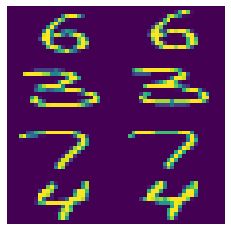

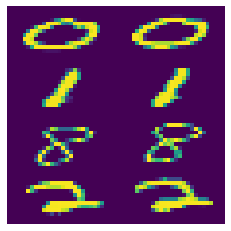

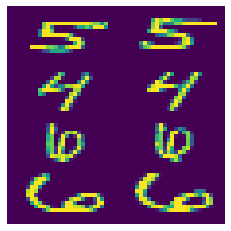

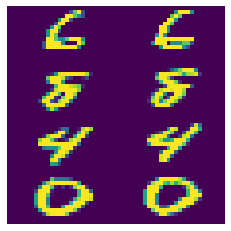

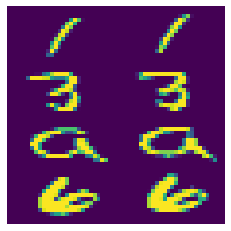

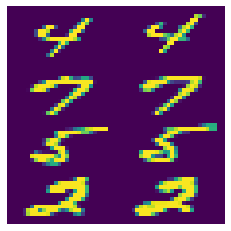

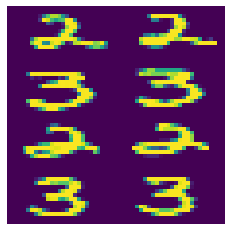

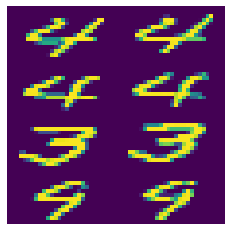

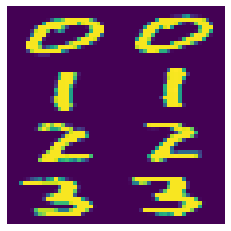

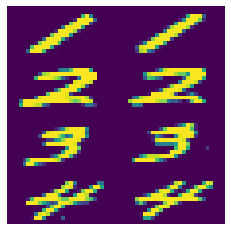

testing accuracy: 0.9420
predicted labels:  [tensor([6, 3, 7, 4]), tensor([0, 1, 8, 2]), tensor([5, 4, 6, 6]), tensor([6, 8, 4, 0]), tensor([1, 3, 0, 6]), tensor([4, 7, 5, 2]), tensor([2, 3, 2, 3]), tensor([4, 4, 3, 9]), tensor([0, 1, 2, 3]), tensor([1, 2, 3, 4])]
actual labels:  [tensor([6, 3, 7, 4]), tensor([0, 1, 8, 2]), tensor([5, 4, 6, 6]), tensor([6, 8, 4, 0]), tensor([1, 3, 9, 6]), tensor([4, 7, 5, 2]), tensor([2, 3, 2, 3]), tensor([4, 4, 3, 9]), tensor([0, 1, 2, 3]), tensor([1, 2, 3, 4])]


In [13]:
MLP_model = torch.load('../Desktop/MLP_model.pt') #load the model that we saved for the best epoch
MLP_model.eval() #evaluate the model

correct = 0 #initialize number correct to 0
total = 0 #initialize total to 0
random_digits = random.sample(range(0, len(testloader)), 10) #generate 10 UNIQUE random digits for getting 10 random images
counter = 0 #see if counter == a number in random_digits
random_predicted = [] #list of predicted values for the 10 random images
random_labels = [] #list of correct labels for the 10 random images

with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
    for data in testloader: #compute accuracy on testing data
        images, labels = data #our data consists of (images, labels)
        #Variable class is a wrapper over torch Tensors and is necessary for PyTorch to forward propogate
        images = Variable(images.contiguous().view(-1, 784)) #reshape images to work with model class
        outputs = MLP_model(images) #get outputs from our model from forward prop
        _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
        total += labels.size(0) #total number of labels
        correct += (predicted == labels).sum().item() #total number of correct predictions
        if counter in random_digits: #check to see if our counter is in the random_digits list we created
            random_predicted.append(predicted) #add the respective image's predicted value to our predicted list
            random_labels.append(labels) #add the respective image's actual value to our labels list
            plt.imshow(images.reshape((56,56))) #shape of the image is 56,56 and needs to be reshaped to be shown
            plt.axis("off")
            plt.show()
        counter += 1 #increment counter
        
accuracy = correct/total #accuracy is the number correctly predicted divided by total number of labels
print('testing accuracy: %.4f' % accuracy)
print('predicted labels: ', random_predicted)
print('actual labels: ', random_labels)

### 3) CNN

In [14]:
#get the train, test, and validation sets for pytorch using MNIST
transform = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) #here we initialize the mnist training set (to be split up later)
#split the dataset (originally train) into train and validation sets, 75/25
train_size = int(0.75*len(dataset))
val_size = int(0.25*len(dataset))
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size]) #here we initialize train and validation sets
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) #here we initialize the mnist test set

In [15]:
#Step 1: Load and prepare dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
valloader = torch.utils.data.DataLoader(testset, batch_size=4)

In [16]:
#Step 2: Define a model
class CNN(nn.Module):
    #2 convolutional layers, 1 pooling layer, 3 fully connected layers
    def __init__(self):
        super(CNN, self).__init__() #super calls the __init__ method of the parent class, here nn.Module
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1) #create our first convolutional layer, call on 1-channel images and input of size 16, padding = (kernel_size - 1)/2
        self.pool = nn.MaxPool2d(2, 2) #create our pooling layer, do max pooling, with kernel=2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1) #create our second convolutional layer, take in 16 units, output 32, padding = (kernel_size - 1)/2
        #here we make our 3 fully connected layers
        self.fc1 = nn.Linear(32*7*7, 120) #first fully connected layer, the size of our data is 32*7*7, output is 120 which we pass into fc2
        self.fc2 = nn.Linear(120, 84) #second fully connected layer, take in 120 from fc1 above, output is 84 which we pass into fc3
        self.fc3 = nn.Linear(84, 10) #third fully connected layer, take in 84 from fc2 above, lastly output size is 10

    def forward(self, x):
        #with F, we can apply activation functions, so we must use it for relu
        output = self.pool(F.relu(self.conv1(x))) #max pooling on the relu-activated first convolutional layer
        output = self.pool(F.relu(self.conv2(output))) #max pooling on the relu-activated second convolutional layer
        output = output.view(output.size(0), -1) #this correctly reshapes output before pushing into fully connected layers
        #3 fully connected layers
        output = F.relu(self.fc1(output)) #relu-activate the first fully connected layer
        output = F.relu(self.fc2(output)) #relu-activate the second fully connected layer
        output = self.fc3(output) #our result is the third and last fully connected layer
        return output
    

CNN_model = CNN()

In [17]:
#Step 3: Define training options
criterion = nn.CrossEntropyLoss() #compute softmax cross entropy loss
optimizer = optim.SGD(CNN_model.parameters(), lr=0.001, momentum=0.9) #use stochastic gradient descent as our learning algorithm

#### Training the network and evaluating accuracy

In [18]:
#Step 4: Train the network
best_val_loss = 1 #for keeping track of best accuracy across all epochs
best_epoch = 1 #for keeping track of the best epoch based on validation loss

for epoch in range(10): #let's do 10 epochs
    
    train_loss_per_epoch = [] #keep a list of the losses for each epoch, then take the average loss for one epoch
    validation_loss = [] #keep a running list of the losses on the validation data
    running_loss = 0.0 #initialize loss to 0
    
    for i, data in enumerate(trainloader): #go through each image/label in the training data
        images, labels = data #our data consists of (images, labels)
        optimizer.zero_grad() #zero the parameter gradients
        outputs = CNN_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        loss.backward() #backpropogate, computes the gradients
        optimizer.step() #optimize
        
        #print stats
        running_loss += loss.item() #add up losses
        if i % 128 == 127: #print every mini-batch of size 128
            train_loss_per_epoch.append(running_loss/128)
            running_loss = 0.0 #reset loss
            
    print('epoch: ', epoch + 1, 'training loss: ', sum(train_loss_per_epoch)/len(train_loss_per_epoch))
            
    #run the validation set through the network, check for loss and accuracy
    for i, data in enumerate(valloader): #go through each image/label in the validation data
        images, labels = data #our data consists of (images, labels)
        optimizer.zero_grad() #zero the parameter gradients
        outputs = CNN_model(images) #get outputs from our model from forward prop
        loss = criterion(outputs, labels) #calculate loss
        #calculate gradient of matrix
        loss.backward() #backpropogate
        #apply gradient from last step to matrix
        optimizer.step() #optimize
        
        running_loss += loss.item() #add up losses
            
    val_loss = running_loss/len(valloader) #divide running loss by the length of valloader to get the average loss
    print('epoch: ', epoch + 1, 'validation loss:', val_loss) #we run on entire set, not in mini-batches
    
    if val_loss < best_val_loss: #check which epoch is best based on lowest validation loss
        torch.save(CNN_model, '../Desktop/CNN_model.pt') #save the model
        best_val_loss = val_loss #save the new best (lowest) loss
        best_epoch = epoch + 1 #save the best epoch
    
#Step 5: Evaluate the network
    correct = 0 #initialize number correct to 0
    total = 0 #initialize total to 0

    with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
        for data in valloader: #compute accuracy on validation data
            images, labels = data #our data consists of (images, labels)
            outputs = CNN_model(images) #run forward prop to get the outputs
            _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
            total += labels.size(0) #total number of labels
            correct += (predicted == labels).sum().item() #total number of correct predictions

    accuracy = correct/total #accuracy is the number correctly predicted divided by total number of labels
    print('epoch: ', epoch + 1, 'validation accuracy: %.4f' % accuracy)
        
            
print('FINISHED TRAINING')
print('best epoch for this model: ', best_epoch)

epoch:  1 training loss:  0.404280606787063
epoch:  1 validation loss: 0.08446367767971205
epoch:  1 validation accuracy: 0.9724
epoch:  2 training loss:  0.07686176406611597
epoch:  2 validation loss: 0.04861722118781721
epoch:  2 validation accuracy: 0.9865
epoch:  3 training loss:  0.05289938869103615
epoch:  3 validation loss: 0.03258879251042179
epoch:  3 validation accuracy: 0.9907
epoch:  4 training loss:  0.0399095026800167
epoch:  4 validation loss: 0.025617241003121093
epoch:  4 validation accuracy: 0.9937
epoch:  5 training loss:  0.031146325099464033
epoch:  5 validation loss: 0.018416127350402673
epoch:  5 validation accuracy: 0.9932
epoch:  6 training loss:  0.025613950806762275
epoch:  6 validation loss: 0.014532454504289208
epoch:  6 validation accuracy: 0.9960
epoch:  7 training loss:  0.02110031352251652
epoch:  7 validation loss: 0.01046801366050395
epoch:  7 validation accuracy: 0.9991
epoch:  8 training loss:  0.01690522446382767
epoch:  8 validation loss: 0.008513

#### Parts d, g) Now that we know our best epoch for this model, we'll load the model and run our test data on that. Then we'll plot 10 randomly selected digits and report their predicted and actual labels.

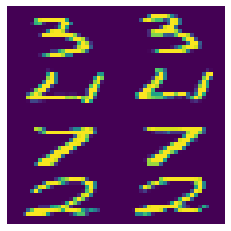

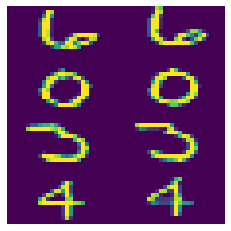

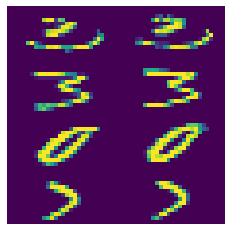

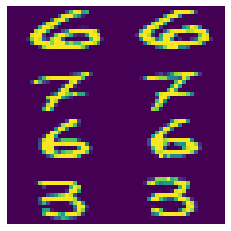

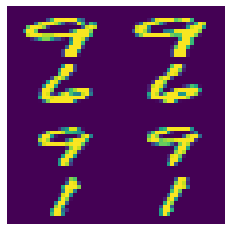

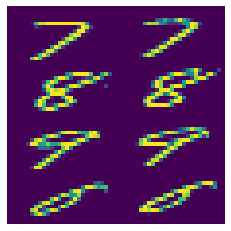

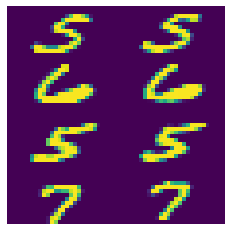

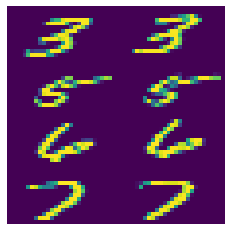

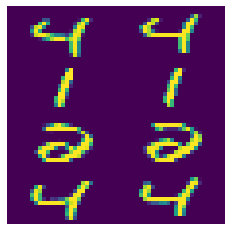

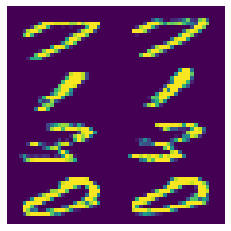

testing accuracy: 0.9966
predicted labels:  [tensor([3, 4, 7, 2]), tensor([6, 0, 3, 4]), tensor([3, 3, 0, 7]), tensor([6, 7, 6, 3]), tensor([9, 6, 9, 1]), tensor([7, 8, 9, 0]), tensor([5, 6, 5, 7]), tensor([3, 5, 6, 7]), tensor([4, 1, 2, 4]), tensor([7, 1, 3, 0])]
actual labels:  [tensor([3, 4, 7, 2]), tensor([6, 0, 3, 4]), tensor([3, 3, 0, 7]), tensor([6, 7, 6, 3]), tensor([9, 6, 9, 1]), tensor([7, 8, 9, 0]), tensor([5, 6, 5, 7]), tensor([3, 5, 6, 7]), tensor([4, 1, 2, 4]), tensor([7, 1, 3, 0])]


In [19]:
CNN_model = torch.load('../Desktop/CNN_model.pt') #load the model that we saved for the best epoch
CNN_model.eval() #evaluate the model

correct = 0 #initialize number correct to 0
total = 0 #initialize total to 0
random_digits = random.sample(range(0, len(testloader)), 10) #generate 10 UNIQUE random digits for getting 10 random images
counter = 0 #see if counter == a number in random_digits
random_predicted = [] #list of predicted values for the 10 random images
random_labels = [] #list of correct labels for the 10 random images

with torch.no_grad(): #allow the weights to have no gradients, otherwise causes error in backpropagation
    for data in testloader: #compute accuracy on testing data
        images, labels = data #our data consists of (images, labels)
        outputs = CNN_model(images) #run forward prop to get the outputs
        _, predicted = torch.max(outputs.data, 1) #make a prediction based on outputs
        total += labels.size(0) #total number of labels
        correct += (predicted == labels).sum().item() #total number of correct predictions
        if counter in random_digits: #check to see if our counter is in the random_digits list we created
            random_predicted.append(predicted) #add the respective image's predicted value to our predicted list
            random_labels.append(labels) #add the respective image's actual value to our labels list
            plt.imshow(images.reshape((56,56))) #shape of the image is 56,56 and needs to be reshaped to be shown
            plt.axis("off")
            plt.show()
        counter += 1 #increment counter
        
accuracy = correct/total #accuracy is the number correctly predicted divided by total number of labels
print('testing accuracy: %.4f' % accuracy)
print('predicted labels: ', random_predicted)
print('actual labels: ', random_labels)

#### Great accuracy!